In [ ]:
!pip install torch torchvision pycocotools


In [4]:
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from pycocotools.coco import COCO
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [5]:
class DhakaTrafficDataset(Dataset):
    def __init__(self, root, annotation, transform=None):
        self.root = root
        self.coco = COCO(annotation)
        self.ids = list(self.coco.imgs.keys())
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        img_metadata = coco.loadImgs(img_id)[0]
        path = os.path.join(self.root, img_metadata['file_name'])

        image = Image.open(path).convert("RGB")
        boxes = []
        labels = []

        for ann in anns:
            xmin = ann['bbox'][0]
            ymin = ann['bbox'][1]
            xmax = xmin + ann['bbox'][2]
            ymax = ymin + ann['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(ann['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        if self.transform:
            image = self.transform(image)

        return image, target

# Define transforms with data augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create datasets
train_dataset = DhakaTrafficDataset(
    root="/kaggle/input/dhaka-city-traffic-2024/Final_Dhaka_Traffic_Dataset/train",
    annotation="/kaggle/input/dhaka-city-traffic-2024/Final_Dhaka_Traffic_Dataset/train/_combined_annotations.coco.json",
    transform=transform
)

val_dataset = DhakaTrafficDataset(
    root="/kaggle/input/dhaka-city-traffic-2024/Final_Dhaka_Traffic_Dataset/valid",
    annotation="/kaggle/input/dhaka-city-traffic-2024/Final_Dhaka_Traffic_Dataset/valid/_combined_annotations.coco.json",
    transform=transform
)

test_dataset = DhakaTrafficDataset(
    root="/kaggle/input/dhaka-city-traffic-2024/Final_Dhaka_Traffic_Dataset/test",
    annotation="/kaggle/input/dhaka-city-traffic-2024/Final_Dhaka_Traffic_Dataset/test/_combined_annotations.coco.json",
    transform=transform
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


loading annotations into memory...
Done (t=1.21s)
creating index...
index created!
loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


In [37]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load a pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the head of the model for the number of classes in the dataset
num_classes = 10  # 9 object classes + 1 background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move model to the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer and learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
# Load the pre-trained model
model_path = "/kaggle/input/better-models-faster-rcnn/model_epoch_17.pth"

# Re-create the model and load the trained weights
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = 10  # 9 object classes + 1 background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()  # Set model to evaluation mode


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
# import torchvision.transforms as transforms
# from torchvision.datasets import DatasetFolder
# from torch.utils.data import DataLoader
# from tqdm import tqdm
# # Define evaluation function
# def evaluate_mAP(data_loader):
#     model.eval()
#     pred_boxes = []
#     true_boxes = []

#     with torch.no_grad():
#         for images, targets in tqdm(data_loader, desc="Evaluating"):
#             images = [image.to(device) for image in images]
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#             outputs = model(images)

#             for output, target in zip(outputs, targets):
#                 pred_boxes.append(output['boxes'].cpu().numpy())
#                 true_boxes.append(target['boxes'].cpu().numpy())

#     return pred_boxes, true_boxes

# # Evaluate on training set
# train_pred_boxes, train_true_boxes = evaluate_mAP(train_loader)
# # Evaluate on validation set
# val_pred_boxes, val_true_boxes = evaluate_mAP(val_loader)
# # Evaluate on test set
# test_pred_boxes, test_true_boxes = evaluate_mAP(test_loader)



In [ ]:
# from sklearn.metrics import average_precision_score
# import numpy as np

# def compute_mAP(pred_boxes, true_boxes, num_classes):
#     all_precisions = []
#     for i in range(len(pred_boxes)):
#         pred_box = pred_boxes[i]
#         true_box = true_boxes[i]

#         # Verify the structure of the boxes
#         if len(pred_box) > 0:
#             pred_box = np.hstack((np.zeros((pred_box.shape[0], 1)), pred_box))
#         if len(true_box) > 0:
#             true_box = np.hstack((np.zeros((true_box.shape[0], 1)), true_box))

#         precisions = []
#         for class_idx in range(num_classes):
#             if len(pred_box) > 0:
#                 class_pred = pred_box[np.where(pred_box[:, 0] == class_idx)][:, 1:]
#             else:
#                 class_pred = np.array([])

#             if len(true_box) > 0:
#                 class_true = true_box[np.where(true_box[:, 0] == class_idx)][:, 1:]
#             else:
#                 class_true = np.array([])

#             if len(class_true) == 0:
#                 precisions.append(0)
#             else:
#                 precision = average_precision_score(np.ones(len(class_true)), np.zeros(len(class_true)))
#                 precisions.append(precision)

#         all_precisions.append(np.mean(precisions))

#     mAP = np.mean(all_precisions)
#     return mAP

# # Assume num_classes is defined or set it appropriately
# num_classes = 10  # Set this to the actual number of classes in your dataset

# # Compute mAP for training set
# train_mAP = compute_mAP(train_pred_boxes, train_true_boxes, num_classes)
# print("Training mAP:", train_mAP)

# # Compute mAP for validation set
# val_mAP = compute_mAP(val_pred_boxes, val_true_boxes, num_classes)
# print("Validation mAP:", val_mAP)

# # Compute mAP for test set
# test_mAP = compute_mAP(test_pred_boxes, test_true_boxes, num_classes)
# print("Test mAP:", test_mAP)


In [ ]:
# import torch
# import numpy as np
# from sklearn.metrics import precision_recall_curve, average_precision_score

# def calculate_iou(box1, box2):
#     if len(box1) != 4 or len(box2) != 4:
#         raise ValueError("Bounding boxes should have 4 elements (x1, y1, x2, y2).")
    
#     x1, y1, x2, y2 = box1
#     x1_gt, y1_gt, x2_gt, y2_gt = box2

#     xi1 = max(x1, x1_gt)
#     yi1 = max(y1, y1_gt)
#     xi2 = min(x2, x2_gt)
#     yi2 = min(y2, y2_gt)
#     inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

#     box1_area = (x2 - x1) * (y2 - y1)
#     box2_area = (x2_gt - x1_gt) * (y2_gt - y1_gt)
#     union_area = box1_area + box2_area - inter_area

#     iou = inter_area / union_area
#     return iou

# def compute_mAP(pred_boxes, true_boxes, num_classes, iou_threshold=0.5):
#     average_precisions = []

#     for class_idx in range(num_classes):
#         true_class_boxes = []
#         pred_class_boxes = []
#         scores = []

#         for i in range(len(pred_boxes)):
#             pred_box = pred_boxes[i]
#             true_box = true_boxes[i]

#             # Ensure bounding boxes have the correct format
#             if len(pred_box) > 0 and len(pred_box[0]) == 6:  # Assuming format [class, x1, y1, x2, y2, score]
#                 class_pred = pred_box[pred_box[:, 0] == class_idx][:, 1:5]
#                 class_scores = pred_box[pred_box[:, 0] == class_idx][:, -1]
#             else:
#                 class_pred = np.array([])
#                 class_scores = np.array([])

#             if len(true_box) > 0 and len(true_box[0]) == 5:  # Assuming format [class, x1, y1, x2, y2]
#                 class_true = true_box[true_box[:, 0] == class_idx][:, 1:]
#             else:
#                 class_true = np.array([])

#             for pred in class_pred:
#                 if len(pred) != 4:
#                     continue  # Skip incorrectly formatted bounding boxes
                
#                 ious = np.array([calculate_iou(pred, gt) for gt in class_true])
#                 max_iou_idx = np.argmax(ious) if len(ious) > 0 else -1
#                 if len(ious) > 0 and ious[max_iou_idx] >= iou_threshold:
#                     true_class_boxes.append(1)
#                 else:
#                     true_class_boxes.append(0)

#                 scores.append(class_scores[max_iou_idx] if max_iou_idx != -1 else 0)
#                 pred_class_boxes.append(pred)

#         if true_class_boxes and scores:
#             precision, recall, _ = precision_recall_curve(true_class_boxes, scores)
#             ap = average_precision_score(true_class_boxes, scores) if true_class_boxes else 0
#             average_precisions.append(ap)

#     mAP = np.mean(average_precisions) if average_precisions else 0
#     return mAP

# # Assume num_classes is defined or set it appropriately
# num_classes = 10  # Set this to the actual number of classes in your dataset

# # Evaluate mAP on train, validation, and test sets
# train_mAP = compute_mAP(train_pred_boxes, train_true_boxes, num_classes)
# val_mAP = compute_mAP(val_pred_boxes, val_true_boxes, num_classes)
# test_mAP = compute_mAP(test_pred_boxes, test_true_boxes, num_classes)

# print("Training mAP:", train_mAP)
# print("Validation mAP:", val_mAP)
# print("Test mAP:", test_mAP)


In [ ]:
# import numpy as np
# import torch
# from sklearn.cluster import DBSCAN
# import matplotlib.pyplot as plt
# vehicle_classes=[1, 2, 3, 4, 5, 6, 8, 9]
# # Function to detect objects using the trained model
# def detect_objects(image_tensor, model, device, threshold=0.5):
#     model.eval()
#     with torch.no_grad():
#         prediction = model([image_tensor.to(device)])[0]

#     boxes = prediction['boxes'].cpu().numpy()
#     scores = prediction['scores'].cpu().numpy()
#     labels = prediction['labels'].cpu().numpy()

#     filtered_boxes = boxes[scores >= threshold]
#     filtered_labels = labels[scores >= threshold]

#     return filtered_boxes, filtered_labels

# # Function to detect congested regions using DBSCAN clustering
# def detect_congested_regions(boxes, eps=75, min_samples=5):
#     if len(boxes) == 0:
#         return []

#     centroids = np.array([((box[0] + box[2]) / 2, (box[1] + box[3]) / 2) for box in boxes])
#     clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(centroids)
#     cluster_labels = clustering.labels_

#     congested_regions = []
#     for cluster in set(cluster_labels):
#         if cluster == -1:
#             continue  # Ignore noise points

#         cluster_boxes = [boxes[i] for i, label in enumerate(cluster_labels) if label == cluster]
#         x_min = min(box[0] for box in cluster_boxes)
#         y_min = min(box[1] for box in cluster_boxes)
#         x_max = max(box[2] for box in cluster_boxes)
#         y_max = max(box[3] for box in cluster_boxes)

#         congested_regions.append([x_min, y_min, x_max, y_max])

#     return congested_regions

# # Function to analyze an image and count vehicles, people, and congested regions
# def analyze_image(image, model, device, vehicle_classes, eps, min_samples, threshold=0.5):
#     boxes, labels = detect_objects(image, model, device, threshold)
#     vehicle_boxes = [box for box, label in zip(boxes, labels) if label in vehicle_classes]
#     people_boxes = [box for box, label in zip(boxes, labels) if label == 7]  # Assuming "People" class ID is 7

#     congested_regions = detect_congested_regions(vehicle_boxes, eps, min_samples)
#     vehicle_count = len(vehicle_boxes)
#     people_count = len(people_boxes)
#     congestion_count = len(congested_regions)
#     people_in_congested_areas = sum(1 for box in people_boxes if any(
#         x_min <= box[0] <= x_max and y_min <= box[1] <= y_max for x_min, y_min, x_max, y_max in congested_regions))

#     return {
#         "vehicle_count": vehicle_count,
#         "people_count": people_count,
#         "congested_regions": congested_regions,
#         "congestion_count": congestion_count,
#         "people_in_congested_areas": people_in_congested_areas,
#         "vehicle_boxes": vehicle_boxes  # Add the vehicle_boxes key
#     }

# # Define the range of values for eps and min_samples to explore
# eps_values = [50, 75, 100, 125, 150]
# min_samples_values = [3, 5, 7, 10]

# # Initialize dictionaries to store the results
# results_per_combination = {(eps, min_samples): {'congestion_count': 0} for eps in eps_values for min_samples in min_samples_values}

# for images, _ in val_loader:
#     for image in images:
#         # Analyze the image using different combinations of eps and min_samples
#         for eps in eps_values:
#             for min_samples in min_samples_values:
#                 results = analyze_image(image, model, device, vehicle_classes, eps=eps, min_samples=min_samples)
#                 congestion_count = results['congestion_count']
#                 # Update the results dictionary with the congestion count for each combination
#                 results_per_combination[(eps, min_samples)]['congestion_count'] += congestion_count


# # Find the optimal combination of eps and min_samples
# optimal_combination = min(results_per_combination, key=lambda x: results_per_combination[x]['congestion_count'])

# # Print the optimal combination
# print("Optimal combination of eps and min_samples:", optimal_combination) #Optimal combination of eps and min_samples: (50, 10)



In [10]:
def interpret_congestion(results):
    # Check the number of congested regions
    if len(results["congested_regions"]) > 0:
        congestion_level = "Heavy Congestion"
    else:
        congestion_level = "Light Congestion"

    return congestion_level


In [11]:
import numpy as np
import torch
from sklearn.cluster import DBSCAN

import torch

def detect_objects(image_tensor, model, device, threshold=0.5):
    model.eval()
    with torch.no_grad():
        prediction = model([image_tensor.to(device)])[0]

    boxes = prediction['boxes'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()

    filtered_boxes = boxes[scores >= threshold]
    filtered_labels = labels[scores >= threshold]

#     # Debugging step: print the detected boxes and labels
#     print(f"Detected boxes: {filtered_boxes}")
#     print(f"Detected labels: {filtered_labels}")

    return filtered_boxes, filtered_labels



import matplotlib.pyplot as plt

def detect_congested_regions(boxes, eps=75, min_samples=5):
    if len(boxes) == 0:
        return []

    centroids = np.array([((box[0] + box[2]) / 2, (box[1] + box[3]) / 2) for box in boxes])
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(centroids)
    cluster_labels = clustering.labels_

#     # Debugging step: plot centroids and their clusters
#     plt.figure(figsize=(10, 10))
#     plt.scatter(centroids[:, 0], centroids[:, 1], c=cluster_labels, cmap='viridis', marker='o')
#     plt.title('DBSCAN Clustering of Vehicle Centroids')
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.colorbar(label='Cluster Label')
#     plt.show()

    congested_regions = []
    for cluster in set(cluster_labels):
        if cluster == -1:
            continue  # Ignore noise points

        cluster_boxes = [boxes[i] for i, label in enumerate(cluster_labels) if label == cluster]
        x_min = min(box[0] for box in cluster_boxes)
        y_min = min(box[1] for box in cluster_boxes)
        x_max = max(box[2] for box in cluster_boxes)
        y_max = max(box[3] for box in cluster_boxes)

        congested_regions.append([x_min, y_min, x_max, y_max])

#     # Debugging step: print the detected congested regions
#     print(f"Congested regions: {congested_regions}")

    return congested_regions


def analyze_image(image, model, device, vehicle_classes, eps=75, min_samples=5, threshold=0.5):
    boxes, labels = detect_objects(image, model, device, threshold)
    vehicle_boxes = [box for box, label in zip(boxes, labels) if label in vehicle_classes]
    people_boxes = [box for box, label in zip(boxes, labels) if label == 7]  # Assuming "People" class ID is 7

    congested_regions = detect_congested_regions(vehicle_boxes, eps, min_samples)
    vehicle_count = len(vehicle_boxes)
    people_count = len(people_boxes)
    congestion_count = len(congested_regions)
    people_in_congested_areas = sum(1 for box in people_boxes if any(
        x_min <= box[0] <= x_max and y_min <= box[1] <= y_max for x_min, y_min, x_max, y_max in congested_regions))

#     # Debugging step: print the analysis results
#     print(f"Vehicle count: {vehicle_count}")
#     print(f"People count: {people_count}")
#     print(f"Congestion count: {congestion_count}")
#     print(f"People in congested areas: {people_in_congested_areas}")

    return {
        "vehicle_count": vehicle_count,
        "people_count": people_count,
        "congested_regions": congested_regions,
        "congestion_count": congestion_count,
        "people_in_congested_areas": people_in_congested_areas,
    }


# Example usage
image, target = next(iter(test_loader))
results = analyze_image(image[0], model, device, vehicle_classes=[1, 2, 3, 4, 5, 6, 8, 9])  # Adjust based on class IDs
print(results)


{'vehicle_count': 23, 'people_count': 4, 'congested_regions': [[175.94656, 123.34937, 375.40375, 415.21686]], 'congestion_count': 1, 'people_in_congested_areas': 0}


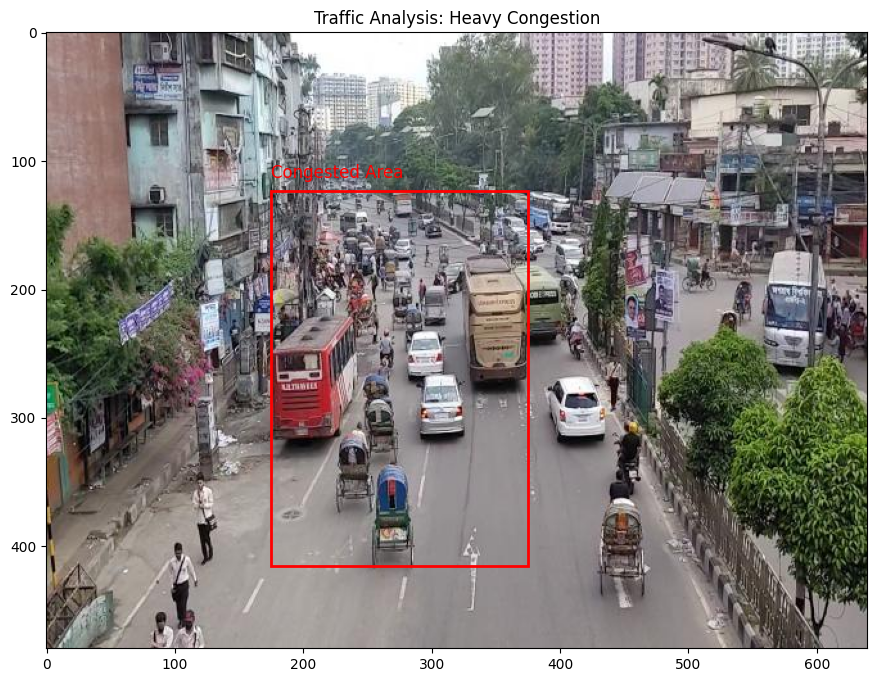

In [16]:
def visualize_results(image, results, congestion_level):
    plt.figure(figsize=(12, 8))
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    for box in results["congested_regions"]:
        x_min, y_min, x_max, y_max = map(int, box)
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                          edgecolor='red', facecolor='none', linewidth=2))
        plt.text(x_min, y_min - 10, 'Congested Area', color='red', fontsize=12)

    plt.title(f"Traffic Analysis: {congestion_level}")
    plt.show()


# Example usage
# Interpret congestion based on detected regions
congestion_level = interpret_congestion(results)
visualize_results(image[0], results, congestion_level)


{'vehicle_count': 9, 'people_count': 6, 'congested_regions': [], 'congestion_count': 0, 'people_in_congested_areas': 0}


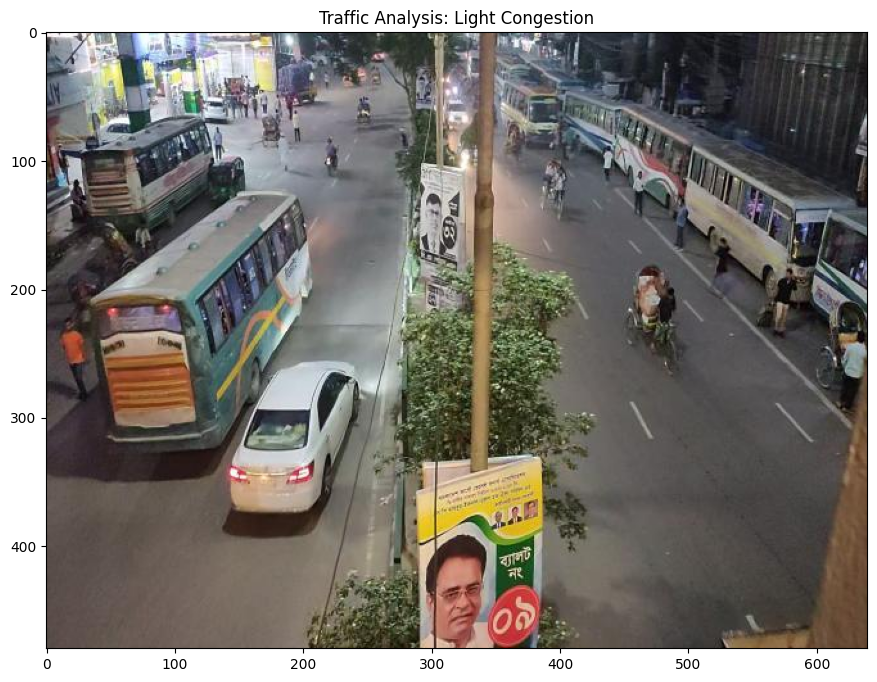

In [18]:
# Example usage
results = analyze_image(image[2], model, device, vehicle_classes=[1, 2, 3, 4, 5, 6, 8, 9])  # Adjust based on class IDs
print(results)
# Interpret congestion based on detected regions
congestion_level = interpret_congestion(results)
visualize_results(image[2], results, congestion_level)